In [1]:
from Bio import Entrez
Entrez.email = 'shl198@eng.ucsd.edu'
import re,os,sarge
import pandas as pd
from natsort import natsorted
from Bio import SeqIO
from IPython.display import Markdown
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# import seaborn

In [2]:
thread = 36
#----------------- PASA related parameter ----------------
pasa = '/home/shangzhong/Installation/PASApipeline-2.0.2'
ppl_fn = pasa + '/scripts/Launch_PASA_pipeline.pl'
config = pasa + '/pasa_conf/pasa.alignAssembly.Template.txt'
db = 'picr_db_stringtie'
#----------------- transdecoder related parameter --------
transde_code_path = '/home/shangzhong/Installation/TransDecoder-v5.0.2'
#----------------- Annotation related parameter ----------
path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
hamster_id = '/data/shangzhong/Database/hamster/hamster_all_id.txt'
ref_fa = '/data/genome/hamster/picr_old/picr.fa'
rna_fa = path + '/hamster_rna.fa'
pr_fa  = path + '/hamster_pr.fa'
uniprot_fa = path + '/uniprot_sprot.fasta'
stringtie_gtf = path + '/stringtie_merge.gtf'

#----------------- Don't need to change the following parameter --------------
trans2hamster = path + '/map2hamster.txt'
trans2uniprot = path + '/map2uniprot.txt'
pasa2hamrna = path + '/map2hamrna.txt'

#### 1. Merge stringtie gff and gmap mapping results

In [3]:
def align_assemble(ppl_fn,config,ref_fa,rna_fa,thread,stringtie_gtf,otherParameters=['']):
    '''This function do alignment assembly
    generate 4 type of files: 
    sample_mydb_pasa.assemblies.fasta :the PASA assemblies in FASTA format.
    sample_mydb_pasa.pasa_assemblies.gff3,.gtf,.bed :the PASA assembly structures.
    sample_mydb_pasa.pasa_alignment_assembly_building.ascii_illustrations.out :descriptions 
        of alignment assemblies and how they were constructed from the underlying transcript alignments.
    sample_mydb_pasa.pasa_assemblies_described.txt :tab-delimited format describing the contents
         of the PASA assemblies, including the identity of those transcripts that were assembled into the corresponding structure.
    '''
    cmd = ('{ppl} -c {config} -C -r -R -g {ref_fa} --cufflinks_gtf {stringtie}\
             -t {rna_fa} --ALIGNERS gmap --CPU {thread} {other} ').format(ppl=ppl_fn,config=config,
            ref_fa=ref_fa,stringtie=stringtie_gtf,rna_fa=rna_fa,thread=str(thread),other=' '.join(otherParameters))
    sarge.run(cmd)

In [4]:
pasa_res_path = path + '/pasa_assem'
pasa_gff = pasa_res_path + '/' + db + '.pasa_assemblies.gff3'
pasa_desp = pasa_res_path + '/' + db + '.pasa_assemblies_described.txt'
pasa_assm = pasa_res_path + '/' + db + '.assemblies.fasta'
os.chdir(pasa_res_path)
if not os.path.exists(pasa_gff):
    align_assemble(ppl_fn,config,ref_fa,rna_fa,thread,stringtie_gtf,otherParameters=[''])

#### Predict proteins in PASA assemblies using transdecoder

In [5]:
transde_path = path + '/transdecoder'
if not os.path.exists(transde_path): os.mkdir(transde_path)
os.chdir(transde_path)
# transde_gff = transde_path + '/' + db + '.assemblies.fasta.transdecoder.gff3'
transde_pep = transde_path + '/' + db + '.assemblies.fasta.transdecoder.pep'
trans_gene_gff = transde_path + '/' + db + '.transdecoder.genome.gff3'
# get ORF longer than 100 AA
if not os.path.exists(trans_gene_gff):
    cmd = ('{trans} -t {rna_fa}').format(trans=transde_code_path+'/TransDecoder.LongOrfs',rna_fa=pasa_assm)
    sarge.run(cmd)
    cmd = ('{trans} -t {rna_fa}').format(trans=transde_code_path+'/TransDecoder.Predict',rna_fa=pasa_assm)
    sarge.run(cmd)
    cmd = ('{orf2orf} {tran_gff} {pasa_gff} {pasa_assm} > {out_gff}').format(
        orf2orf=transde_code_path+'/util/cdna_alignment_orf_to_genome_orf.pl',tran_gff=transde_gff,
        pasa_gff=pasa_gff,pasa_assm=pasa_assm,out_gff=trans_gene_gff)
    sarge.run(cmd)

#### BLAST predicted proteins to hamster refseq proteins and uniprot proteins

In [6]:
def makeblastdb(fastaFile,datatype,out_path,outputname):
    """
    this function build database given a fasta file
    * fastaFile: can be gzipped or not
    """
    if not os.path.exists(out_path):os.mkdir(out_path)
    os.chdir(out_path)
    cmd = ('makeblastdb -in {input} -dbtype {type} -title {title} -out {outputname}').format(
        input=fastaFile,type=datatype,outputname=outputname,title=outputname)
    sarge.run(cmd)
    
def blastp(query,outputFile,database,thread,mapnum=1):
    """
    This function run blastp
    * query: fasta file which you want to map
    * database: database path/name
    * outputFile: tabular blast result
    """
    cmd = ('blastp -query {inf} -db {database} -out {outputFile} '
           '-evalue 1e-4 -outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue qlen slen\' '
           '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,outputFile=outputFile,thread=str(thread),mapnum=str(mapnum))
    sarge.run(cmd)

def blastn(query,outputFile,database,thread,mapnum=1):
    ''''''
    cmd = ('blastn -query {inf} -db {database} -out {out} -evalue 1e-4 '
           '-outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue qlen slen\' '
          '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,out=outputFile,thread=str(thread),mapnum=str(mapnum))
#     print cmd
    sarge.run(cmd)


In [7]:
# build protein database
ham_db = path + '/hamster_blastDb'
uni_db = path + '/uniprot_blastDb'
ham_rna_db = path + '/hamster_rna_blastDb'
if not os.path.exists(ham_db):
    makeblastdb(pr_fa,'prot',ham_db,'hamster')
if not os.path.exists(uni_db):
    makeblastdb(uniprot_fa,'prot',uni_db,'uniprot')
if not os.path.exists(ham_rna_db):
    makeblastdb(rna_fa,'nucl',ham_rna_db,'hamster')
# blastp
os.chdir(transde_path)
map2ham = transde_path + '/map2hamster.txt'
map2uni = transde_path + '/map2uniprot.txt'
map2ham_rna = transde_path + '/map2ham_rna.txt'
if not os.path.exists(map2ham):
    blastp(transde_pep,map2ham,ham_db+'/hamster',thread)
if not os.path.exists(map2uni):
    blastp(transde_pep,map2uni,uni_db+'/uniprot',thread)
if not os.path.exists(map2ham_rna):
    blastn(pasa_assm,map2ham_rna,ham_rna_db+'/hamster',thread)

#### 2. Get gene, assembly, transcripts mapping from pasa descriptions.
Genes can have multiple assebmlies, each assembly maps to many transcripts. 
Here we build an assembly as {gene:{assemble#:[MSTR,XM_**]}}

In [8]:
gene_assm_tr_dic = {} # {gene:{assemble:[MSTG,XM_****]}}
assm_geneclust_dic = {} # {assmbl:gene}
geneclust_chrom_dic = {} # {geneclustid:chr}
with open(pasa_desp) as f:
    for line in f:
        if line.strip() == '' or line.startswith('#'):
            continue
        item = line.strip().split('\t')
        chrom = item[0]
        gene  = item[1]
        rna  = item[2]
        geneclust_chrom_dic[gene] = chrom
        assm_geneclust_dic[rna] = gene
        trs   = [tr if tr.startswith('MSTRG') else tr.split('.')[0] for tr in item[3].split(',')]
        if gene not in gene_assm_tr_dic:
            gene_assm_tr_dic[gene] = {rna:trs}
        else:
            if rna not in gene_assm_tr_dic[gene]:
                gene_assm_tr_dic[gene][rna] = trs
            else:
                gene_assm_tr_dic[gene][rna].extend(trs)

#### PASA assembly splice positions
The assembly is gff file that has all positions of transcripts from PASA.
{assembly:[chr+strand,[s1,e1],[s2,e2]}

In [9]:
pasa_pos_dic = {}
with open(pasa_gff) as f:
    for line in f:
        if line.strip() == '' or line.startswith('#'):
            continue
        item = line.strip().split('\t')
        chrom = item[0]
        start = int(item[3])
        end = int(item[4])
        strand = item[6]
        anno = item[8]
        tr = re.search('(?<=Target=).+?(?=\ )',anno).group(0)
        if tr not in pasa_pos_dic:
            pasa_pos_dic[tr] = [chrom+strand,[start,end]]
        else:
            pasa_pos_dic[tr].append([start,end])

#### Build gene, traccess, praccess mapping

In [10]:
# build gene, traccess, pr access mapping
def gene_rna_pr_id_map(hamster_id,access,out_fn):
    '''this fnction get all gene rna pr id, including both refseq and gff information.
    * hamster_id: a file that has all ids in hamster.gff file
    * access
    * out_fn:  
    '''
    # rna accession in gff file
    ham_id_df = pd.read_csv(hamster_id,sep='\t',header=0)
    ham_id_df = ham_id_df.astype('str')
    ham_id_df['TrAccess'] = ham_id_df['TrAccess'].map(lambda x: x.split('.')[0])
    ham_id_df['PrAccess'] = ham_id_df['PrAccess'].map(lambda x: x.split('.')[0])
    rna_gene_dic = ham_id_df.set_index('TrAccess')['GeneID'].to_dict()
    rna_pr_dic = ham_id_df.set_index('TrAccess')['PrAccess'].to_dict()
    rna_gname_dic = ham_id_df.set_index('TrAccess')['GeneSymbol'].to_dict()
    # new rna in refseq compared to gff
    new_ref_rna = list(set(access) - set(rna_gene_dic.keys()))
    # get geneid for new ref_rna gene id
    for r in new_ref_rna:
        if r.startswith('MSTRG'):
            rna_gene_dic[r] = '.'.join(r.split('.')[:2])
            rna_pr_dic[r] = '-'
            rna_gname_dic[r] = '.'.join(r.split('.')[:2])
        else:
            handle = Entrez.efetch(db='nucleotide',id=r,rettype='gb',retmode='text').read()
            
            geneid = re.search('(?<=GeneID:).+?(?=\")',handle).group(0)
            gename = re.search('(?<=gene=\").+?(?=\")',handle).group(0)
            try:
                p = re.search('(?<=protein_id=\").+?(?=\.)',handle).group(0)
            except:
                p = '-'
            rna_gene_dic[r] = geneid
            rna_pr_dic[r] = p
            rna_gname_dic[r] = gename
    # transfer dic to dataframe
    r_g_df = pd.DataFrame.from_dict(rna_gene_dic,'index')
    r_g_df.columns = ['geneid']
    r_p_df = pd.DataFrame.from_dict(rna_pr_dic,'index')
    r_p_df.columns = ['pr_ac']
    r_n_df = pd.DataFrame.from_dict(rna_gname_dic,'index')
    r_n_df.columns = ['gename']
    g_r_p_df = pd.concat([r_g_df,r_n_df,r_p_df],axis=1)
    g_r_p_df['rna_ac'] = g_r_p_df.index
    g_r_p_df[['geneid','gename','rna_ac','pr_ac']].to_csv(out_fn,sep='\t',index=False)

In [11]:
id_fn = path + '/01_gene_tr_pr.txt'
if not os.path.exists(id_fn):
    rna_access = []
    for record in SeqIO.parse(rna_fa,'fasta'):
        rna_access.append(record.id.split('.')[0])
    gene_rna_pr_id_map(hamster_id,rna_access,id_fn)

#### 4. build transdecoder and pr position
{cds_pr_id:[chrom+strand,[s,e],...]}

In [12]:
trans_pr_pos_dic = {}
with open(trans_gene_gff) as f:
    for line in f:
        if line.strip() == '' or line.startswith('#'): continue
        item = line.split('\t')
        chrom = item[0]
        start = int(item[3])
        end = int(item[4])
        strand = item[6]
        anno = item[8]
        if item[2] =='CDS':
            fid = re.search('(?<=ID=).+?(?=;)',anno).group(0)[4:]
            if fid not in trans_pr_pos_dic:
                trans_pr_pos_dic[fid] = [chrom+strand,[start,end]]
            else:
                trans_pr_pos_dic[fid].append([start,end])

#### 4. Categorize mapping of predicted proteins to hamster ref and uniprot

In [13]:
id_df = pd.read_csv(id_fn,sep='\t',header=0)
id_df = id_df.query('(pr_ac != \'-\')')
id_df = id_df.reset_index(drop=True)

ham_pr2gnm_dic = id_df.set_index('pr_ac')['gename'].to_dict()

In [14]:
trans2hamster_df = pd.read_csv(map2ham,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])
trans2hamster_df['sacc'] = trans2hamster_df['sacc'].map(lambda x: x.split('.')[0])
trans2hamster_df['gnm'] = trans2hamster_df['sacc'].map(lambda x: ham_pr2gnm_dic[x].upper() 
                        if x in ham_pr2gnm_dic else x)
trans2hamster_df = trans2hamster_df.query('evalue<1e-4')

trans2uniprot_df = pd.read_csv(map2uni,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])

trans2uniprot_df['gnm']=trans2uniprot_df['sacc'].map(lambda x: x.split('|')[-1].split('_')[0])
trans2uniprot_df = trans2uniprot_df.query('evalue<1e-4')

In [15]:
m = trans2hamster_df['qacc'].unique().shape[0]
n = trans2uniprot_df['qacc'].unique().shape[0]

i = trans2hamster_df.query('(pident==100) and (length==slen==qlen-1)').shape[0]
j = trans2uniprot_df.query('(pident==100) and (length==slen==qlen-1)').shape[0]

o = trans2hamster_df['sacc'].unique().shape[0]
p = trans2uniprot_df['sacc'].unique().shape[0]

In [16]:
print 'there are',len(pasa_pos_dic),'transcripts in pasa assemblies'
print 'there are 32836 proteins in hamster refseq proteins,28784 unique proteins'
print 'transdecoder generates 64598 proteins in total'
print m,'of them map to',o,'hamster refseq proteins'
print n,'of them map to',p,'uniprot swissprot proteins'
print '\n'
print i,'proteins map perfectly to hamster refseq'
print j,'proteins map perfectly to uniprot proteins'

there are 86790 transcripts in pasa assemblies
there are 32836 proteins in hamster refseq proteins,28784 unique proteins
transdecoder generates 64598 proteins in total
65546 of them map to 25302 hamster refseq proteins
65643 of them map to 20127 uniprot swissprot proteins


23103 proteins map perfectly to hamster refseq
1050 proteins map perfectly to uniprot proteins


For unfilter data,
64113 of them map to 25589 hamster refseq proteins
63950 of them map to 22512 uniprot swissprot proteins
21503 proteins map perfectly to hamster refseq
915 proteins map perfectly to uniprot proteins

score=length * pident, if the two proteins map in multiple fragments format, the blast results reports in multiple lines, here we want to get statistics on the transcripts that have same/different gene names when mapping to the hamster refseq and uniprot proteins, os we get the highest score for each pair of mappings and then plot the distribution.

In [17]:
# score=length*pident, if one 
sub1 = trans2hamster_df[['qacc','sacc','gnm','pident','length']]
sub2 = trans2uniprot_df[['qacc','gnm','pident','length']]
sub1.loc[:,'score'] = sub1['pident']*sub1['length']
sub2.loc[:,'score'] = sub2['pident']*sub2['length']
# get the item with maximum score
idx = sub1.groupby('qacc')['score'].transform(max)==sub1['score']
sub1 = sub1[idx]
sub1 = sub1.groupby('qacc').first()
idx = sub2.groupby('qacc')['score'].transform(max)==sub2['score']
sub2 = sub2[idx]
sub2 = sub2.groupby('qacc').first()
# merge the two by index, which is qacc
ham_uni_id = pd.merge(sub1,sub2,how='outer',left_index=True,right_index=True)
ham_uni_id.columns = ['sacc', 'gnm_x', 'map2hamster', 'length_x', 'score_x', 
                      'gnm_y', 'map2uniprot', 'length_y', 'score_y']
pr_assms = [a.split('.')[0] for a in ham_uni_id.index.unique()]

/opt/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
same_name_df = ham_uni_id.query('(gnm_y==gnm_x)')
diff_name_df = ham_uni_id.query('gnm_y!=gnm_x')
print 'there are',same_name_df.shape[0],'transcripts have the same mapping gene names to hamster refseq and uniprot'
print 'there are',diff_name_df.shape[0],'transcripts have different mapping gene names to hamster refseq and uniprot'

there are 25439 transcripts have the same mapping gene names to hamster refseq and uniprot
there are 40641 transcripts have different mapping gene names to hamster refseq and uniprot


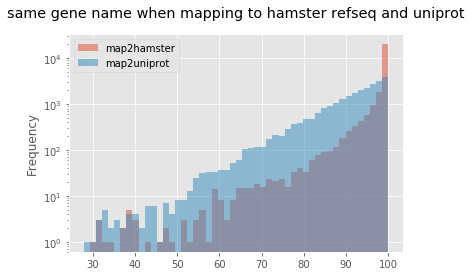

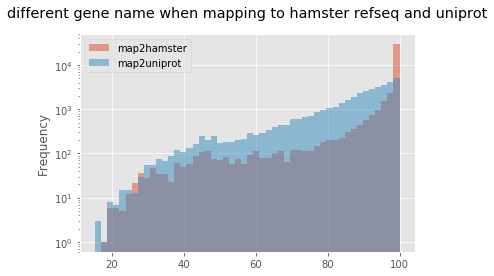

In [19]:
ax = same_name_df[['map2hamster','map2uniprot']].plot(kind='hist',bins=50,alpha=0.5)
_ = ax.set_title('same gene name when mapping '
                'to hamster refseq and uniprot')
_ = ax.set_yscale('log')
ttl = ax.title
ttl.set_position([.5, 1.05])

ax = diff_name_df[['map2hamster','map2uniprot']].plot(kind='hist',bins=50,alpha=0.5)
_ = ax.set_title('different gene name '
                 'when mapping to hamster refseq and uniprot')
_ = ax.set_yscale('log')
ttl = ax.title
ttl.set_position([.5, 1.05])

From the figure above, we can see that for transcripts that have the same gene name when mapping to hamster refseq and uniprot, the cut off for hamster refseq is 60%, for uniprot is 50%. So I will use these thresholds to categorize the confidence level of the transcripts.

In [20]:
same_name_abv_6050 = same_name_df.query('map2hamster>=60 and map2uniprot>=50').index.unique().tolist()
same_name_blw_6050 = list(set(same_name_df.index.unique())-set(same_name_abv_6050))
diff_name_abv_6050 = diff_name_df.query('map2hamster>=60 and map2uniprot>=50').index.unique()
diff_name_blw_6050 = list(set(diff_name_df.index.unique())-set(diff_name_abv_6050))
print 'there are',len(same_name_abv_6050),'transcripts have same name above 6050 percent'
print 'there are',len(same_name_blw_6050),'transcripts have same name below 6050 percent'
print 'there are',len(diff_name_abv_6050),'transcripts have diff name above 6050 percent'
print 'there are',len(diff_name_blw_6050),'transcripts have diff name below 6050 percent'

there are 25359 transcripts have same name above 6050 percent
there are 80 transcripts have same name below 6050 percent
there are 37230 transcripts have diff name above 6050 percent
there are 3411 transcripts have diff name below 6050 percent


#### 5. Get long noncoding RNAs

In [21]:
map2hamrna_df = pd.read_csv(map2ham_rna,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])
map2hamrna_df['score'] = map2hamrna_df['length']*map2hamrna_df['pident']
map2hamrna_df = map2hamrna_df[map2hamrna_df['sacc'].str.startswith('XR_')]

In [22]:
idx = map2hamrna_df.groupby('qacc')['score'].transform(max)==map2hamrna_df['score']
map2hamrna_df=map2hamrna_df[idx]

lncRNA = map2hamrna_df['qacc'].unique().tolist()
lncRNA = list(set(lncRNA)-set(pr_assms))
print 'there are',len(lncRNA),'assmblies map to',map2hamrna_df['sacc'].unique().size,'long non coding rnas'

there are 8953 assmblies map to 5214 long non coding rnas


In [23]:
# build dictionary {asmb_id:gename}
ham_only_assm_nm_dic = ham_uni_id[ham_uni_id['gnm_y'].isnull()]['gnm_x'].to_dict()
# uni_only_assm_nm_dic = ham_uni_id[ham_uni_id['gnm_x'].isnull()]['gnm_y'].to_dict()
# change the key name to assmblies id
assm_gnm_dic = ham_uni_id['gnm_y'].to_dict()
for key in assm_gnm_dic.keys():
    assm_gnm_dic[key.split('.')[0]] = assm_gnm_dic.pop(key)
for key,v in ham_only_assm_nm_dic.iteritems():
    assm_gnm_dic[key.split('.')[0]] = v

In [24]:
rest_assms = set(pasa_pos_dic.keys())-set(lncRNA)- set(pr_assms)

#### 6. Generate gff file
store all the exon and cds into one dictionary

In [25]:
def prepare_gff(assms,all_rna_dic,pasa_pos_dic,trans_pr_pos_dic,cs,feature='mRNA'):
    '''
    feature: lncRNA or mRNA
    cs: confidence score
    '''
    for assm in assms:
        rnaid = assm.split('.')[0]
        gid = 'gene_'+assm_geneclust_dic[rnaid]
        try:
            gnm = assm_gnm_dic[rnaid]
        except:
            gnm = gid
        #-------------- get transcript positions
        rna_pos = pasa_pos_dic[rnaid]
        rna_chr = rna_pos[0][:-1]
        rna_str = rna_pos[0][-1]
        if rna_str == '+':
            tr_pos = sorted(rna_pos[1:],key=lambda x:x[0])
        else:
            tr_pos = sorted(rna_pos[1:],key=lambda x:x[0],reverse=True)

        # add mRNA and exon lines
        rna_s = min(tr_pos,key=lambda x:x[0])[0]
        rna_e = max(tr_pos,key=lambda x:x[1])[1]
        anno = 'ID={r};Parent={gid};gene_id={gid};Name={gnm};transcript_id={r};cs={c}'.format(
                        r=rnaid,gid=gid,gnm=gnm,c=str(cs))
        item = [rna_chr,'merge',feature,str(rna_s),str(rna_e),'.',rna_str,'.',anno]
        all_rna_dic[rnaid]=[item]
        n = 0
        for r in tr_pos:
            n +=1
            anno='ID={r}.exon{n};Parent={r};gene_id={gid};Name={gnm};transcript_id={r}'.format(
                        r=rnaid,n=str(n),gid=gid,gnm=gnm)
            item = [rna_chr,'merge','exon',str(r[0]),str(r[1]),'.',rna_str,'.',anno]
            all_rna_dic[rnaid].append(item)
        #---------------- get protein position
        try:
            pro_pos = trans_pr_pos_dic[assm]
            pro_chr = pro_pos[0][:-1]
            pro_str = pro_pos[0][-1]
            if pro_str == '+':
                pr_pos = sorted(pro_pos[1:],key=lambda x:x[0])
            else:
                pr_pos = sorted(pro_pos[1:],key=lambda x:x[0],reverse=True)
            if pro_pos[0] != rna_pos[0]:
                assert False,rnaid+' rna and protein sequence is not consistent on chr or str'
            n = 0
            for p in pr_pos:
                n +=1
                anno='ID={r}.cds{n};Parent={r};gene_id={gid};Name={gnm};protein_id={r}'.format(
                r=rnaid,n=str(n),gid=gid,gnm=gnm)
                item = [rna_chr,'merge','CDS',str(p[0]),str(p[1]),'.',rna_str,'.',anno]
                all_rna_dic[rnaid].append(item)
        except:
            print assm,'has problem'
            pass
    return all_rna_dic

In [26]:
rna_all_dic = {}
rna_all_dic = prepare_gff(same_name_abv_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,1)
rna_all_dic = prepare_gff(same_name_blw_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,2)
rna_all_dic = prepare_gff(diff_name_abv_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,3)
rna_all_dic = prepare_gff(diff_name_blw_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,4)
rna_all_dic = prepare_gff(lncRNA,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,1,'lncRNA')
rna_all_dic = prepare_gff(rest_assms,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,5)

asmbl_11179.p1 has problem
asmbl_11331.p1 has problem
asmbl_11629.p1 has problem
asmbl_11631.p1 has problem
asmbl_11632.p1 has problem
asmbl_11633.p1 has problem
asmbl_11717.p1 has problem
asmbl_1231.p1 has problem
asmbl_1232.p1 has problem
asmbl_1234.p1 has problem
asmbl_1238.p1 has problem
asmbl_1239.p1 has problem
asmbl_13196.p1 has problem
asmbl_13206.p1 has problem
asmbl_13258.p1 has problem
asmbl_13635.p2 has problem
asmbl_13718.p2 has problem
asmbl_13840.p1 has problem
asmbl_13879.p1 has problem
asmbl_14318.p3 has problem
asmbl_14473.p1 has problem
asmbl_14483.p2 has problem
asmbl_15161.p1 has problem
asmbl_15398.p3 has problem
asmbl_15444.p1 has problem
asmbl_15520.p2 has problem
asmbl_15527.p1 has problem
asmbl_15542.p1 has problem
asmbl_15543.p1 has problem
asmbl_15653.p1 has problem
asmbl_15654.p1 has problem
asmbl_15695.p1 has problem
asmbl_16264.p1 has problem
asmbl_16333.p2 has problem
asmbl_16346.p2 has problem
asmbl_16370.p1 has problem
asmbl_16395.p1 has problem
asmbl_

asmbl_49128.p1 has problem
asmbl_49129.p1 has problem
asmbl_4913.p1 has problem
asmbl_49130.p1 has problem
asmbl_49275.p1 has problem
asmbl_50085.p1 has problem
asmbl_50543.p1 has problem
asmbl_50639.p1 has problem
asmbl_5064.p1 has problem
asmbl_51281.p1 has problem
asmbl_51865.p1 has problem
asmbl_51883.p1 has problem
asmbl_51970.p1 has problem
asmbl_52120.p1 has problem
asmbl_52129.p1 has problem
asmbl_52178.p1 has problem
asmbl_52858.p1 has problem
asmbl_52859.p1 has problem
asmbl_52861.p1 has problem
asmbl_52862.p1 has problem
asmbl_52863.p1 has problem
asmbl_52864.p1 has problem
asmbl_52865.p1 has problem
asmbl_52866.p1 has problem
asmbl_52867.p1 has problem
asmbl_52868.p1 has problem
asmbl_52869.p1 has problem
asmbl_52871.p1 has problem
asmbl_52872.p1 has problem
asmbl_52873.p1 has problem
asmbl_52874.p1 has problem
asmbl_52875.p1 has problem
asmbl_52876.p1 has problem
asmbl_52877.p1 has problem
asmbl_52878.p1 has problem
asmbl_53085.p1 has problem
asmbl_5325.p1 has problem
asmb

asmbl_14294.p2 has problem
asmbl_14376.p1 has problem
asmbl_14528.p1 has problem
asmbl_14544.p1 has problem
asmbl_14736.p1 has problem
asmbl_14739.p1 has problem
asmbl_14740.p1 has problem
asmbl_14741.p1 has problem
asmbl_14759.p1 has problem
asmbl_14908.p1 has problem
asmbl_15069.p3 has problem
asmbl_15070.p3 has problem
asmbl_15083.p2 has problem
asmbl_15084.p3 has problem
asmbl_15085.p3 has problem
asmbl_15086.p3 has problem
asmbl_15087.p3 has problem
asmbl_15089.p3 has problem
asmbl_15090.p3 has problem
asmbl_15091.p3 has problem
asmbl_15092.p3 has problem
asmbl_15093.p3 has problem
asmbl_15173.p1 has problem
asmbl_15230.p6 has problem
asmbl_15342.p2 has problem
asmbl_1552.p1 has problem
asmbl_15534.p1 has problem
asmbl_1556.p1 has problem
asmbl_15561.p3 has problem
asmbl_1571.p1 has problem
asmbl_15882.p1 has problem
asmbl_16004.p1 has problem
asmbl_16011.p2 has problem
asmbl_16087.p1 has problem
asmbl_16103.p1 has problem
asmbl_1618.p1 has problem
asmbl_1620.p1 has problem
asmbl_

asmbl_31828.p1 has problem
asmbl_31894.p1 has problem
asmbl_3194.p1 has problem
asmbl_31964.p1 has problem
asmbl_31965.p1 has problem
asmbl_31967.p2 has problem
asmbl_32065.p2 has problem
asmbl_32066.p2 has problem
asmbl_32067.p2 has problem
asmbl_32068.p1 has problem
asmbl_32108.p1 has problem
asmbl_32109.p1 has problem
asmbl_32333.p1 has problem
asmbl_32334.p1 has problem
asmbl_32335.p1 has problem
asmbl_32338.p1 has problem
asmbl_32343.p1 has problem
asmbl_32356.p1 has problem
asmbl_32754.p1 has problem
asmbl_32810.p1 has problem
asmbl_32828.p1 has problem
asmbl_32829.p1 has problem
asmbl_32851.p1 has problem
asmbl_33014.p1 has problem
asmbl_33123.p1 has problem
asmbl_33155.p1 has problem
asmbl_33156.p1 has problem
asmbl_33157.p1 has problem
asmbl_33205.p1 has problem
asmbl_33284.p1 has problem
asmbl_33351.p1 has problem
asmbl_33415.p1 has problem
asmbl_33477.p2 has problem
asmbl_33516.p1 has problem
asmbl_33526.p1 has problem
asmbl_33532.p1 has problem
asmbl_33533.p1 has problem
as

asmbl_54744.p1 has problem
asmbl_54927.p1 has problem
asmbl_54940.p1 has problem
asmbl_54945.p1 has problem
asmbl_54958.p1 has problem
asmbl_54959.p1 has problem
asmbl_5499.p2 has problem
asmbl_54990.p1 has problem
asmbl_54993.p1 has problem
asmbl_54994.p1 has problem
asmbl_54995.p1 has problem
asmbl_54996.p3 has problem
asmbl_55006.p1 has problem
asmbl_5503.p2 has problem
asmbl_5504.p2 has problem
asmbl_55040.p1 has problem
asmbl_5505.p2 has problem
asmbl_5506.p2 has problem
asmbl_55122.p2 has problem
asmbl_55123.p1 has problem
asmbl_55124.p1 has problem
asmbl_55125.p3 has problem
asmbl_55129.p1 has problem
asmbl_5531.p1 has problem
asmbl_55443.p1 has problem
asmbl_55620.p1 has problem
asmbl_55723.p1 has problem
asmbl_55731.p1 has problem
asmbl_55746.p1 has problem
asmbl_55860.p1 has problem
asmbl_55863.p3 has problem
asmbl_55883.p1 has problem
asmbl_5594.p1 has problem
asmbl_55940.p2 has problem
asmbl_5595.p1 has problem
asmbl_5596.p1 has problem
asmbl_5598.p1 has problem
asmbl_56041

asmbl_84685.p1 has problem
asmbl_84737.p2 has problem
asmbl_84781.p1 has problem
asmbl_8480.p1 has problem
asmbl_84817.p1 has problem
asmbl_8487.p1 has problem
asmbl_8488.p1 has problem
asmbl_85147.p1 has problem
asmbl_85152.p1 has problem
asmbl_85153.p1 has problem
asmbl_85194.p1 has problem
asmbl_85200.p1 has problem
asmbl_85217.p1 has problem
asmbl_85308.p1 has problem
asmbl_85309.p1 has problem
asmbl_85335.p1 has problem
asmbl_85459.p1 has problem
asmbl_85460.p1 has problem
asmbl_85524.p2 has problem
asmbl_85529.p1 has problem
asmbl_85596.p1 has problem
asmbl_85605.p1 has problem
asmbl_85631.p1 has problem
asmbl_85746.p1 has problem
asmbl_85756.p1 has problem
asmbl_85889.p1 has problem
asmbl_85949.p1 has problem
asmbl_86052.p1 has problem
asmbl_86081.p1 has problem
asmbl_86434.p1 has problem
asmbl_86467.p1 has problem
asmbl_86480.p1 has problem
asmbl_86592.p2 has problem
asmbl_86667.p2 has problem
asmbl_86749.p1 has problem
asmbl_8893.p1 has problem
asmbl_905.p2 has problem
asmbl_9

asmbl_13255 has problem
asmbl_34085 has problem
asmbl_73849 has problem
asmbl_52933 has problem
asmbl_50679 has problem
asmbl_73843 has problem
asmbl_73842 has problem
asmbl_73841 has problem
asmbl_73840 has problem
asmbl_6592 has problem
asmbl_73844 has problem
asmbl_40481 has problem
asmbl_40480 has problem
asmbl_40483 has problem
asmbl_40482 has problem
asmbl_40484 has problem
asmbl_40487 has problem
asmbl_40489 has problem
asmbl_40488 has problem
asmbl_79562 has problem
asmbl_43460 has problem
asmbl_43466 has problem
asmbl_43465 has problem
asmbl_27365 has problem
asmbl_58471 has problem
asmbl_58470 has problem
asmbl_5161 has problem
asmbl_5162 has problem
asmbl_50496 has problem
asmbl_50495 has problem
asmbl_74005 has problem
asmbl_76866 has problem
asmbl_76862 has problem
asmbl_76647 has problem
asmbl_76860 has problem
asmbl_15174 has problem
asmbl_76648 has problem
asmbl_76649 has problem
asmbl_5348 has problem
asmbl_6925 has problem
asmbl_6924 has problem
asmbl_66401 has proble

asmbl_57929 has problem
asmbl_28627 has problem
asmbl_28624 has problem
asmbl_28628 has problem
asmbl_72014 has problem
asmbl_72010 has problem
asmbl_9626 has problem
asmbl_9625 has problem
asmbl_9621 has problem
asmbl_18606 has problem
asmbl_80628 has problem
asmbl_3489 has problem
asmbl_3488 has problem
asmbl_49863 has problem
asmbl_3484 has problem
asmbl_3487 has problem
asmbl_3486 has problem
asmbl_3481 has problem
asmbl_18608 has problem
asmbl_18609 has problem
asmbl_47296 has problem
asmbl_32749 has problem
asmbl_32645 has problem
asmbl_37650 has problem
asmbl_65440 has problem
asmbl_65114 has problem
asmbl_65446 has problem
asmbl_65447 has problem
asmbl_65448 has problem
asmbl_69148 has problem
asmbl_30926 has problem
asmbl_56785 has problem
asmbl_30388 has problem
asmbl_32561 has problem
asmbl_32560 has problem
asmbl_3199 has problem
asmbl_27133 has problem
asmbl_27130 has problem
asmbl_22569 has problem
asmbl_28845 has problem
asmbl_39676 has problem
asmbl_39674 has problem
as

asmbl_31639 has problem
asmbl_59653 has problem
asmbl_59871 has problem
asmbl_59656 has problem
asmbl_59657 has problem
asmbl_59654 has problem
asmbl_57895 has problem
asmbl_57898 has problem
asmbl_47582 has problem
asmbl_49756 has problem
asmbl_33678 has problem
asmbl_70149 has problem
asmbl_4210 has problem
asmbl_48809 has problem
asmbl_48801 has problem
asmbl_24639 has problem
asmbl_85648 has problem
asmbl_39966 has problem
asmbl_42809 has problem
asmbl_63932 has problem
asmbl_3654 has problem
asmbl_3650 has problem
asmbl_3651 has problem
asmbl_3652 has problem
asmbl_3653 has problem
asmbl_60073 has problem
asmbl_30713 has problem
asmbl_61709 has problem
asmbl_61708 has problem
asmbl_61703 has problem
asmbl_61707 has problem
asmbl_61706 has problem
asmbl_61705 has problem
asmbl_85645 has problem
asmbl_75010 has problem
asmbl_85647 has problem
asmbl_22456 has problem
asmbl_22455 has problem
asmbl_35423 has problem
asmbl_45062 has problem
asmbl_45063 has problem
asmbl_45064 has proble

asmbl_46693 has problem
asmbl_46690 has problem
asmbl_46691 has problem
asmbl_73951 has problem
asmbl_57654 has problem
asmbl_57655 has problem
asmbl_57656 has problem
asmbl_57657 has problem
asmbl_57650 has problem
asmbl_57651 has problem
asmbl_57652 has problem
asmbl_57653 has problem
asmbl_73952 has problem
asmbl_57658 has problem
asmbl_57659 has problem
asmbl_24613 has problem
asmbl_37332 has problem
asmbl_83130 has problem
asmbl_86452 has problem
asmbl_83134 has problem
asmbl_83135 has problem
asmbl_83136 has problem
asmbl_46076 has problem
asmbl_39274 has problem
asmbl_36422 has problem
asmbl_42633 has problem
asmbl_57695 has problem
asmbl_83060 has problem
asmbl_19155 has problem
asmbl_19154 has problem
asmbl_15865 has problem
asmbl_67506 has problem
asmbl_64312 has problem
asmbl_64311 has problem
asmbl_6036 has problem
asmbl_59969 has problem
asmbl_37599 has problem
asmbl_37598 has problem
asmbl_71249 has problem
asmbl_37595 has problem
asmbl_37594 has problem
asmbl_59962 has p

asmbl_33051 has problem
asmbl_33052 has problem
asmbl_33053 has problem
asmbl_33058 has problem
asmbl_55907 has problem
asmbl_44907 has problem
asmbl_70257 has problem
asmbl_37536 has problem
asmbl_37535 has problem
asmbl_59909 has problem
asmbl_5417 has problem
asmbl_30626 has problem
asmbl_30627 has problem
asmbl_44840 has problem
asmbl_30628 has problem
asmbl_30629 has problem
asmbl_41507 has problem
asmbl_41506 has problem
asmbl_41505 has problem
asmbl_41504 has problem
asmbl_6365 has problem
asmbl_67298 has problem
asmbl_1326 has problem
asmbl_1327 has problem
asmbl_1325 has problem
asmbl_1322 has problem
asmbl_67295 has problem
asmbl_48280 has problem
asmbl_7418 has problem
asmbl_7411 has problem
asmbl_82146 has problem
asmbl_44590 has problem
asmbl_3258 has problem
asmbl_3259 has problem
asmbl_3254 has problem
asmbl_3255 has problem
asmbl_3256 has problem
asmbl_3257 has problem
asmbl_60478 has problem
asmbl_28510 has problem
asmbl_6096 has problem
asmbl_75328 has problem
asmbl_6

asmbl_14637 has problem
asmbl_9618 has problem
asmbl_31261 has problem
asmbl_31260 has problem
asmbl_31262 has problem
asmbl_34239 has problem
asmbl_34238 has problem
asmbl_44429 has problem
asmbl_34231 has problem
asmbl_34232 has problem
asmbl_34235 has problem
asmbl_34234 has problem
asmbl_34237 has problem
asmbl_34236 has problem
asmbl_42218 has problem
asmbl_42219 has problem
asmbl_42216 has problem
asmbl_42217 has problem
asmbl_42214 has problem
asmbl_42215 has problem
asmbl_25867 has problem
asmbl_57919 has problem
asmbl_57918 has problem
asmbl_57917 has problem
asmbl_57916 has problem
asmbl_57915 has problem
asmbl_57914 has problem
asmbl_57912 has problem
asmbl_57911 has problem
asmbl_57910 has problem
asmbl_48474 has problem
asmbl_14874 has problem
asmbl_72048 has problem
asmbl_72049 has problem
asmbl_10851 has problem
asmbl_72043 has problem
asmbl_72044 has problem
asmbl_72046 has problem
asmbl_72047 has problem
asmbl_18989 has problem
asmbl_18988 has problem
asmbl_23426 has p

asmbl_83739 has problem
asmbl_32554 has problem
asmbl_32552 has problem
asmbl_32553 has problem
asmbl_5533 has problem
asmbl_84269 has problem
asmbl_5536 has problem
asmbl_5535 has problem
asmbl_5534 has problem
asmbl_56266 has problem
asmbl_56267 has problem
asmbl_5538 has problem
asmbl_84260 has problem
asmbl_84263 has problem
asmbl_84262 has problem
asmbl_73378 has problem
asmbl_34183 has problem
asmbl_79100 has problem
asmbl_74350 has problem
asmbl_19528 has problem
asmbl_17672 has problem
asmbl_17673 has problem
asmbl_17670 has problem
asmbl_17671 has problem
asmbl_17676 has problem
asmbl_17677 has problem
asmbl_17674 has problem
asmbl_17675 has problem
asmbl_17679 has problem
asmbl_33945 has problem
asmbl_34189 has problem
asmbl_57208 has problem
asmbl_34188 has problem
asmbl_82808 has problem
asmbl_63225 has problem
asmbl_56918 has problem
asmbl_56919 has problem
asmbl_33608 has problem
asmbl_33607 has problem
asmbl_49766 has problem
asmbl_49765 has problem
asmbl_49764 has probl

asmbl_34181 has problem
asmbl_34180 has problem
asmbl_72085 has problem
asmbl_72086 has problem
asmbl_72081 has problem
asmbl_72082 has problem
asmbl_72083 has problem
asmbl_30324 has problem
asmbl_35852 has problem
asmbl_31805 has problem
asmbl_31804 has problem
asmbl_31807 has problem
asmbl_50241 has problem
asmbl_31801 has problem
asmbl_31800 has problem
asmbl_31803 has problem
asmbl_31802 has problem
asmbl_31809 has problem
asmbl_31808 has problem
asmbl_24663 has problem
asmbl_24662 has problem
asmbl_34329 has problem
asmbl_34328 has problem
asmbl_24667 has problem
asmbl_24666 has problem
asmbl_24665 has problem
asmbl_24664 has problem
asmbl_43251 has problem
asmbl_34453 has problem
asmbl_43252 has problem
asmbl_34327 has problem
asmbl_34326 has problem
asmbl_34325 has problem
asmbl_76617 has problem
asmbl_538 has problem
asmbl_42788 has problem
asmbl_42784 has problem
asmbl_42785 has problem
asmbl_42786 has problem
asmbl_42787 has problem
asmbl_73133 has problem
asmbl_536 has prob

asmbl_55233 has problem
asmbl_75983 has problem
asmbl_60350 has problem
asmbl_22632 has problem
asmbl_22633 has problem
asmbl_22630 has problem
asmbl_40236 has problem
asmbl_40237 has problem
asmbl_40891 has problem
asmbl_40894 has problem
asmbl_40238 has problem
asmbl_40239 has problem
asmbl_34165 has problem
asmbl_34164 has problem
asmbl_34167 has problem
asmbl_34166 has problem
asmbl_34161 has problem
asmbl_34160 has problem
asmbl_34163 has problem
asmbl_34162 has problem
asmbl_34169 has problem
asmbl_34168 has problem
asmbl_58206 has problem
asmbl_58207 has problem
asmbl_58205 has problem
asmbl_50774 has problem
asmbl_50775 has problem
asmbl_50772 has problem
asmbl_50773 has problem
asmbl_50770 has problem
asmbl_50771 has problem
asmbl_63142 has problem
asmbl_76145 has problem
asmbl_76144 has problem
asmbl_76143 has problem
asmbl_1769 has problem
asmbl_67300 has problem
asmbl_67655 has problem
asmbl_9540 has problem
asmbl_5860 has problem
asmbl_5863 has problem
asmbl_5862 has probl

asmbl_72960 has problem
asmbl_60100 has problem
asmbl_32214 has problem
asmbl_32213 has problem
asmbl_54611 has problem
asmbl_42479 has problem
asmbl_54619 has problem
asmbl_8202 has problem
asmbl_55566 has problem
asmbl_58113 has problem
asmbl_77226 has problem
asmbl_57702 has problem
asmbl_57703 has problem
asmbl_57700 has problem
asmbl_57701 has problem
asmbl_57706 has problem
asmbl_61529 has problem
asmbl_52400 has problem
asmbl_57705 has problem
asmbl_57708 has problem
asmbl_57709 has problem
asmbl_70448 has problem
asmbl_70449 has problem
asmbl_14762 has problem
asmbl_13754 has problem
asmbl_13025 has problem
asmbl_55704 has problem
asmbl_55705 has problem
asmbl_20922 has problem
asmbl_55702 has problem
asmbl_55703 has problem
asmbl_36823 has problem
asmbl_79209 has problem
asmbl_45666 has problem
asmbl_45667 has problem
asmbl_45664 has problem
asmbl_45665 has problem
asmbl_19229 has problem
asmbl_19228 has problem
asmbl_43327 has problem
asmbl_2329 has problem
asmbl_2328 has pro

asmbl_41646 has problem
asmbl_70602 has problem
asmbl_47421 has problem
asmbl_79526 has problem
asmbl_79527 has problem
asmbl_39867 has problem
asmbl_39866 has problem
asmbl_7609 has problem
asmbl_7608 has problem
asmbl_39863 has problem
asmbl_39862 has problem
asmbl_39861 has problem
asmbl_39860 has problem
asmbl_39869 has problem
asmbl_3779 has problem
asmbl_86577 has problem
asmbl_73377 has problem
asmbl_161 has problem
asmbl_73376 has problem
asmbl_83963 has problem
asmbl_24321 has problem
asmbl_16951 has problem
asmbl_64876 has problem
asmbl_7705 has problem
asmbl_7462 has problem
asmbl_74351 has problem
asmbl_22777 has problem
asmbl_85898 has problem
asmbl_76643 has problem
asmbl_85894 has problem
asmbl_85893 has problem
asmbl_59991 has problem
asmbl_59990 has problem
asmbl_83601 has problem
asmbl_37234 has problem
asmbl_40992 has problem
asmbl_37540 has problem
asmbl_37237 has problem
asmbl_13219 has problem
asmbl_15176 has problem
asmbl_30017 has problem
asmbl_76644 has problem

asmbl_71371 has problem
asmbl_4923 has problem
asmbl_70090 has problem
asmbl_15539 has problem
asmbl_4926 has problem
asmbl_70097 has problem
asmbl_58016 has problem
asmbl_4929 has problem
asmbl_4928 has problem
asmbl_75674 has problem
asmbl_65468 has problem
asmbl_65469 has problem
asmbl_16136 has problem
asmbl_74968 has problem
asmbl_16135 has problem
asmbl_65466 has problem
asmbl_65467 has problem
asmbl_5699 has problem
asmbl_56017 has problem
asmbl_58522 has problem
asmbl_56019 has problem
asmbl_35534 has problem
asmbl_35537 has problem
asmbl_38724 has problem
asmbl_32813 has problem
asmbl_2431 has problem
asmbl_32814 has problem
asmbl_84764 has problem
asmbl_58019 has problem
asmbl_84258 has problem
asmbl_35525 has problem
asmbl_35831 has problem
asmbl_84253 has problem
asmbl_2430 has problem
asmbl_78648 has problem
asmbl_78649 has problem
asmbl_73618 has problem
asmbl_78860 has problem
asmbl_78645 has problem
asmbl_78862 has problem
asmbl_78647 has problem
asmbl_18956 has problem

asmbl_4216 has problem
asmbl_51141 has problem
asmbl_51414 has problem
asmbl_79154 has problem
asmbl_48800 has problem
asmbl_79151 has problem
asmbl_39967 has problem
asmbl_39968 has problem
asmbl_65990 has problem
asmbl_15891 has problem
asmbl_38675 has problem
asmbl_21623 has problem
asmbl_82860 has problem
asmbl_80229 has problem
asmbl_64994 has problem
asmbl_60071 has problem
asmbl_60076 has problem
asmbl_16879 has problem
asmbl_7328 has problem
asmbl_60830 has problem
asmbl_8512 has problem
asmbl_86574 has problem
asmbl_62502 has problem
asmbl_50532 has problem
asmbl_75012 has problem
asmbl_7785 has problem
asmbl_75016 has problem
asmbl_22452 has problem
asmbl_9498 has problem
asmbl_22457 has problem
asmbl_68995 has problem
asmbl_22458 has problem
asmbl_22459 has problem
asmbl_13337 has problem
asmbl_37600 has problem
asmbl_13627 has problem
asmbl_13626 has problem
asmbl_37357 has problem
asmbl_37355 has problem
asmbl_42622 has problem
asmbl_37359 has problem
asmbl_37358 has probl

asmbl_77107 has problem
asmbl_77104 has problem
asmbl_77105 has problem
asmbl_9902 has problem
asmbl_9903 has problem
asmbl_9900 has problem
asmbl_9901 has problem
asmbl_9907 has problem
asmbl_5937 has problem
asmbl_5286 has problem
asmbl_25043 has problem
asmbl_4086 has problem
asmbl_4089 has problem
asmbl_70370 has problem
asmbl_33269 has problem
asmbl_47157 has problem
asmbl_47154 has problem
asmbl_47155 has problem
asmbl_18644 has problem
asmbl_41172 has problem
asmbl_47159 has problem
asmbl_40497 has problem
asmbl_69024 has problem
asmbl_69025 has problem
asmbl_53939 has problem
asmbl_69023 has problem
asmbl_53935 has problem
asmbl_53936 has problem
asmbl_77361 has problem
asmbl_42329 has problem
asmbl_56375 has problem
asmbl_4417 has problem
asmbl_35126 has problem
asmbl_14941 has problem
asmbl_14940 has problem
asmbl_14943 has problem
asmbl_14942 has problem
asmbl_14945 has problem
asmbl_76812 has problem
asmbl_14948 has problem
asmbl_66909 has problem
asmbl_33266 has problem
as

asmbl_70326 has problem
asmbl_78828 has problem
asmbl_31711 has problem
asmbl_31712 has problem
asmbl_66276 has problem
asmbl_66277 has problem
asmbl_57319 has problem
asmbl_69422 has problem
asmbl_69420 has problem
asmbl_69421 has problem
asmbl_69427 has problem
asmbl_69424 has problem
asmbl_69425 has problem
asmbl_15146 has problem
asmbl_69428 has problem
asmbl_69429 has problem
asmbl_84746 has problem
asmbl_49638 has problem
asmbl_78311 has problem
asmbl_84742 has problem
asmbl_20386 has problem
asmbl_84740 has problem
asmbl_56805 has problem
asmbl_49631 has problem
asmbl_49630 has problem
asmbl_4339 has problem
asmbl_3452 has problem
asmbl_4330 has problem
asmbl_3451 has problem
asmbl_22823 has problem
asmbl_52366 has problem
asmbl_22821 has problem
asmbl_26873 has problem
asmbl_26702 has problem
asmbl_26877 has problem
asmbl_79672 has problem
asmbl_48943 has problem
asmbl_18046 has problem
asmbl_52368 has problem
asmbl_54404 has problem
asmbl_21734 has problem
asmbl_53367 has prob

asmbl_55572 has problem
asmbl_55571 has problem
asmbl_55570 has problem
asmbl_68738 has problem
asmbl_55575 has problem
asmbl_55574 has problem
asmbl_68733 has problem
asmbl_80971 has problem
asmbl_80973 has problem
asmbl_75132 has problem
asmbl_70455 has problem
asmbl_75137 has problem
asmbl_75138 has problem
asmbl_13760 has problem
asmbl_57305 has problem
asmbl_53417 has problem
asmbl_66202 has problem
asmbl_20933 has problem
asmbl_20932 has problem
asmbl_20931 has problem
asmbl_20930 has problem
asmbl_55712 has problem
asmbl_55711 has problem
asmbl_58192 has problem
asmbl_58196 has problem
asmbl_36834 has problem
asmbl_64873 has problem
asmbl_22683 has problem
asmbl_22682 has problem
asmbl_26300 has problem
asmbl_22680 has problem
asmbl_22687 has problem
asmbl_22686 has problem
asmbl_22685 has problem
asmbl_22684 has problem
asmbl_22689 has problem
asmbl_26309 has problem
asmbl_60675 has problem
asmbl_45671 has problem
asmbl_13582 has problem
asmbl_13583 has problem
asmbl_13585 has 

asmbl_66607 has problem
asmbl_85151 has problem
asmbl_66604 has problem
asmbl_66609 has problem
asmbl_73278 has problem
asmbl_19914 has problem
asmbl_69369 has problem
asmbl_69368 has problem
asmbl_69365 has problem
asmbl_69364 has problem
asmbl_86497 has problem
asmbl_71690 has problem
asmbl_69360 has problem
asmbl_86492 has problem
asmbl_86493 has problem
asmbl_81923 has problem
asmbl_33303 has problem
asmbl_81925 has problem
asmbl_81924 has problem
asmbl_69782 has problem
asmbl_33309 has problem
asmbl_64600 has problem
asmbl_78876 has problem
asmbl_52262 has problem
asmbl_52261 has problem
asmbl_59507 has problem
asmbl_59504 has problem
asmbl_42619 has problem
asmbl_54032 has problem
asmbl_27752 has problem
asmbl_27753 has problem
asmbl_27757 has problem
asmbl_27754 has problem
asmbl_27755 has problem
asmbl_68986 has problem
asmbl_44967 has problem
asmbl_68984 has problem
asmbl_27759 has problem
asmbl_44962 has problem
asmbl_44963 has problem
asmbl_44961 has problem
asmbl_4134 has p

asmbl_4939 has problem
asmbl_80638 has problem
asmbl_80639 has problem
asmbl_4934 has problem
asmbl_4935 has problem
asmbl_4937 has problem
asmbl_80630 has problem
asmbl_80631 has problem
asmbl_12870 has problem
asmbl_32751 has problem
asmbl_32753 has problem
asmbl_74958 has problem
asmbl_32755 has problem
asmbl_55001 has problem
asmbl_30885 has problem
asmbl_55000 has problem
asmbl_62311 has problem
asmbl_65470 has problem
asmbl_65473 has problem
asmbl_69159 has problem
asmbl_56020 has problem
asmbl_58553 has problem
asmbl_58550 has problem
asmbl_59084 has problem
asmbl_58554 has problem
asmbl_52051 has problem
asmbl_50269 has problem
asmbl_59267 has problem
asmbl_57261 has problem
asmbl_57260 has problem
asmbl_32280 has problem
asmbl_57269 has problem
asmbl_11039 has problem
asmbl_81550 has problem
asmbl_20429 has problem
asmbl_65780 has problem
asmbl_15027 has problem
asmbl_84242 has problem
asmbl_59260 has problem
asmbl_23176 has problem
asmbl_23174 has problem
asmbl_23175 has prob

asmbl_24238 has problem
asmbl_28249 has problem
asmbl_24549 has problem
asmbl_73789 has problem
asmbl_46228 has problem
asmbl_42085 has problem
asmbl_37756 has problem
asmbl_212 has problem
asmbl_86053 has problem
asmbl_42089 has problem
asmbl_42088 has problem
asmbl_216 has problem
asmbl_73785 has problem
asmbl_214 has problem
asmbl_49979 has problem
asmbl_70323 has problem
asmbl_70321 has problem
asmbl_4560 has problem
asmbl_4567 has problem
asmbl_4566 has problem
asmbl_80205 has problem
asmbl_80204 has problem
asmbl_80755 has problem
asmbl_80754 has problem
asmbl_80757 has problem
asmbl_4568 has problem
asmbl_80751 has problem
asmbl_80753 has problem
asmbl_40101 has problem
asmbl_60807 has problem
asmbl_74520 has problem
asmbl_79802 has problem
asmbl_74836 has problem
asmbl_47103 has problem
asmbl_80048 has problem
asmbl_48877 has problem
asmbl_77339 has problem
asmbl_48421 has problem
asmbl_33756 has problem
asmbl_77334 has problem
asmbl_68604 has problem
asmbl_68387 has problem
as

asmbl_55576 has problem
asmbl_20490 has problem
asmbl_75238 has problem
asmbl_75239 has problem
asmbl_11227 has problem
asmbl_11226 has problem
asmbl_75234 has problem
asmbl_75235 has problem
asmbl_75232 has problem
asmbl_75233 has problem
asmbl_75230 has problem
asmbl_11220 has problem
asmbl_13513 has problem
asmbl_13514 has problem
asmbl_63377 has problem
asmbl_44195 has problem
asmbl_44194 has problem
asmbl_20638 has problem
asmbl_77587 has problem
asmbl_58249 has problem
asmbl_20635 has problem
asmbl_41905 has problem
asmbl_77589 has problem
asmbl_6498 has problem
asmbl_35834 has problem
asmbl_31864 has problem
asmbl_50736 has problem
asmbl_50737 has problem
asmbl_31861 has problem
asmbl_6496 has problem
asmbl_2389 has problem
asmbl_50225 has problem
asmbl_83499 has problem
asmbl_25515 has problem
asmbl_25512 has problem
asmbl_25513 has problem
asmbl_45578 has problem
asmbl_83493 has problem
asmbl_40057 has problem
asmbl_83491 has problem
asmbl_83490 has problem
asmbl_83497 has pro

asmbl_22356 has problem
asmbl_38512 has problem
asmbl_31860 has problem
asmbl_10565 has problem
asmbl_25516 has problem
asmbl_65094 has problem
asmbl_49446 has problem
asmbl_25514 has problem
asmbl_78083 has problem
asmbl_53143 has problem
asmbl_46645 has problem
asmbl_39196 has problem
asmbl_46647 has problem
asmbl_46646 has problem
asmbl_46640 has problem
asmbl_39191 has problem
asmbl_39190 has problem
asmbl_27657 has problem
asmbl_46649 has problem
asmbl_27652 has problem
asmbl_50221 has problem
asmbl_36615 has problem
asmbl_36614 has problem
asmbl_36611 has problem
asmbl_36613 has problem
asmbl_36612 has problem
asmbl_36619 has problem
asmbl_2381 has problem
asmbl_25049 has problem
asmbl_65893 has problem
asmbl_61789 has problem
asmbl_46029 has problem
asmbl_61400 has problem
asmbl_2382 has problem
asmbl_83163 has problem
asmbl_54885 has problem
asmbl_76185 has problem
asmbl_39995 has problem
asmbl_39994 has problem
asmbl_33396 has problem
asmbl_33395 has problem
asmbl_33394 has pr

asmbl_48332 has problem
asmbl_57628 has problem
asmbl_24591 has problem
asmbl_21349 has problem
asmbl_44135 has problem
asmbl_44134 has problem
asmbl_44137 has problem
asmbl_40652 has problem
asmbl_1470 has problem
asmbl_1475 has problem
asmbl_24330 has problem
asmbl_62650 has problem
asmbl_24338 has problem
asmbl_62653 has problem
asmbl_62657 has problem
asmbl_81583 has problem
asmbl_9525 has problem
asmbl_9526 has problem
asmbl_56133 has problem
asmbl_81367 has problem
asmbl_81365 has problem
asmbl_81364 has problem
asmbl_5801 has problem
asmbl_4171 has problem
asmbl_4173 has problem
asmbl_70208 has problem
asmbl_4175 has problem
asmbl_70206 has problem
asmbl_70207 has problem
asmbl_48745 has problem
asmbl_56135 has problem
asmbl_48749 has problem
asmbl_35908 has problem
asmbl_72158 has problem
asmbl_72159 has problem
asmbl_82476 has problem
asmbl_82477 has problem
asmbl_12505 has problem
asmbl_12504 has problem
asmbl_82472 has problem
asmbl_82470 has problem
asmbl_82471 has problem


In [28]:
with open(path+'/01_merge.gff3','w') as out:
    for k in natsorted(rna_all_dic.keys()):
        for i in rna_all_dic[k]:
            out.write('\t'.join(i)+'\n')

In [29]:
gene_rna_dic = {}
with open(path+'/01_merge.gff3',) as in_f:
    for line in in_f:
        item = line.strip().split('\t')
        if item[2] in ['mRNA','lncRNA']:
            rnaid = re.search('(?<=ID=).+?(?=;)',item[8]).group(0)
            chrom = item[0]
            strand = item[6]
            geneid = re.search('(?<=gene_id=).+?(?=;)',item[8]).group(0)
            gename = re.search('(?<=Name=).+?(?=;|$)',item[8]).group(0)
            if geneid in gene_rna_dic:
                gene_rna_dic[geneid].append([chrom,rnaid,strand,gename,[int(item[3]),int(item[4])]])
            else:
                gene_rna_dic[geneid] = [[chrom,rnaid,strand,gename,[int(item[3]),int(item[4])]]]

In [30]:
# add gene line in gff
with open(path + '/02_merge_gene.gff3','w') as out_f:
    for gene,rnas in gene_rna_dic.iteritems():
        rnas = sorted(rnas,key=lambda x: (x[0],x[4][0]))
        # get the list of number having the same length with rnas, indicating 
        # whether to write the gene batch line. stores in gene_batch
        n = 0
        gene_batch = []
        gene_pos = {}  # {batch#:[start,end]}
        pre_chrom = ''
        pre_name = ''
        pre_start = pre_end = 0
        for rna in rnas: # [chrom,asmbl_id,[start,end]]
            rna_s = rna[4][0]
            rna_e = rna[4][1]
            if rna[0] != pre_chrom or rna[3] != pre_name:
                n += 1
                gene_batch.append(n)
                gene_pos[n] = [rna_s,rna_e]
            else:
                if rna_s > pre_end:
                    n += 1
                    gene_batch.append(n)
                    gene_pos[n] = [rna_s,rna_e]
                else:
                    gene_batch.append(n)
                    gene_pos[n] = [min(rna_s,gene_pos[n][0]),max(rna_e,gene_pos[n][1])]
            pre_start = rna_s
            pre_end = rna_e
            pre_chrom = rna[0]
            pre_name = rna[3]
        pre_b = 0
        if len(set(gene_batch)) > 1:
            for b,rna in zip(gene_batch,rnas):
                if b != pre_b:
                    anno='ID={g}_{b};gene_id={g}_{b};Name={name}'.format(g=gene,b=str(b),name=rna[3])
                    out_f.write('\t'.join([rna[0],'merge','gene',str(gene_pos[b][0]),
                                        str(gene_pos[b][1]),'.',rna[2],'.',anno])+'\n')
                    rna_all_info = rna_all_dic[rna[1]]
                    for rna_item in rna_all_info:
                        if rna_item[2] in ['mRNA','lncRNA']:
                            rna_item[8]=re.sub('(?<=Parent=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                        rna_item[8]=re.sub('(?<=gene_id=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                        out_f.write('\t'.join(rna_item)+'\n')
                    pre_b = b
                else:
                    rna_all_info = rna_all_dic[rna[1]]
                    for rna_item in rna_all_info:
                        if rna_item[2] in ['mRNA','lncRNA']:
                            rna_item[8]=re.sub('(?<=Parent=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                        rna_item[8]=re.sub('(?<=gene_id=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                        out_f.write('\t'.join(rna_item)+'\n')
        else:
            anno='ID={g};gene_id={g};Name={name}'.format(g=gene,name=rna[3])
            out_f.write('\t'.join([rnas[0][0],'merge','gene',str(gene_pos[1][0]),
                                str(gene_pos[1][1]),'.',rna[2],'.',anno])+'\n')
            for rna in rnas:
                rna_all_info = rna_all_dic[rna[1]]
                for rna_item in rna_all_info:
#                     if rna_item[2] in ['mRNA','lncRNA']:
#                         rna_item[8]=re.sub('(?<=Parent=).+?(?=;)',gene,rna_item[8])
                    out_f.write('\t'.join(rna_item)+'\n')

In [32]:
# add frame information for CDS
with open(path+'/pasa_stringtie.gff3','w') as out, open(path+'/02_merge_gene.gff3') as inf:
    pre_pr = ''
    for line in inf:
        if line.startswith('#'):
            out.write(line)
        else:
            item = line.split('\t')
            if item[2] == 'CDS':
                pr = re.search('(?<=protein_id=).+?(?=$|;)',item[8]).group(0)
                if pr != pre_pr:
                    pre_pr = pr
                    item[7] = '0'
                    n = abs(int(item[3])-int(item[4]))+1
                else:
                    item[7] = str(n % 3)
                    n += abs(int(item[3])-int(item[4]))+1
                out.write('\t'.join(item))
            else:
                out.write(line)